<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>

# Basic spatial operations in  Geo Dataframes

We will review some important formatting processes for geodataframes. As usual, let's do this: 

1. Create a repository named: **geodfprepro**.
2. Clone that repo to a local folder in your computer.
3. In that local folder in your computer, create a folder named **maps** and **data**.
4. Put the **brazilMaps_5641.gpkg**  file that contains the three maps prepared last class into the map folder.
5. Download the shapefile of "Brazil - Subnational Administrative Boundaries" from [here](https://data.humdata.org/dataset/cod-ab-bra) and save it in the maps folder (you need to unzip the file).
6. Download a **CSV** file with information on the airports in Brazil from this [website](https://data.humdata.org/dataset/ourairports-bra), I will save it in my **data** folder:
7. Commit and push.

Let's read _Brazil_5641.gpkg_ from the GitHub link with the help of **geopandas**:

In [1]:
import os


import geopandas as gpd
from  fiona import listlayers

#maps
brazilMaps='https://github.com/CienciaDeDatosEspacial/geodfprepro/raw/main/maps/brazilMaps_5641.gpkg'

#layers in maps
listlayers(brazilMaps)

['country', 'cities', 'rivers']

Retrieving each map (layer):

In [2]:
brazil=gpd.read_file(brazilMaps,layer='country')
brazil_cities=gpd.read_file(brazilMaps,layer='cities')
brazil_rivers=gpd.read_file(brazilMaps,layer='rivers')

We know they share the same CRS:

In [3]:
brazil.crs.to_epsg()==brazil_cities.crs.to_epsg()==brazil_rivers.crs.to_epsg()

True

We also remember that having the same CRS allows one plot with several layers of maps:

<Axes: >

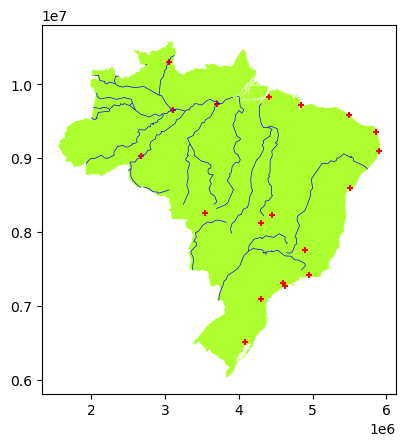

In [4]:
# plotting
base = brazil.plot(facecolor="greenyellow")
brazil_rivers.plot(edgecolor='blue', linewidth=0.5,ax=base)
brazil_cities.plot(marker='+', color='red', markersize=15,ax=base)

Now, let's see some important spatial operations:

1. [Projection](#1)
    * [Projecting Geoseries](#11)
    * 
    * [Projecting Naive Geodata](#12)
    * 
    * [Creating long/lat as spatial data and Re projecting](#13)
    
2. [Dissolving](#2)
3. [Creating Spatial Points](#3)
    * [Creating a convex hull](#31)
4. [Checking Validity](#4)



<a class="anchor" id="11"></a>

## Formating Geoseries projections



You know **brazil_5641** is a multipolygon:

In [5]:
brazil

COUNTRY                                           geometry
0  Brazil  MULTIPOLYGON (((1926257.542 8894978.397, 19262...

Sometime, you just need the border (lines):

In [23]:
brazil.boundary

0    MULTILINESTRING ((1926257.542 8894978.397, 192...
dtype: geometry

<Axes: >

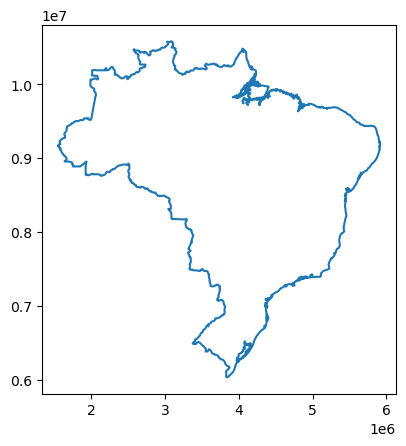

In [7]:
# This is just the borderline
brazil.boundary.plot()

Always check the data type:

In [8]:
# does 'boundary' return a GDF?
type(brazil.boundary)

geopandas.geoseries.GeoSeries

Some operations in geopandas require GDF or GS. If you need a GDF instead of a GS:

In [9]:
# converting into GDF
brazil.boundary.to_frame()

0
0  MULTILINESTRING ((1926257.542 8894978.397, 192...

Notice you get a very simple GDF, and you may want to add some information:

In [10]:
# conversion
brazil_border=brazil.boundary.to_frame() 

# new column (optional)
brazil_border['name']='Brazil' 

# renaming the geometry column
brazil_border.rename(columns={0:'geometry'},inplace=True) 

#setting the geometry (the name is not enough)
brazil_border = brazil_border.set_geometry("geometry")

# verifying:
brazil_border.crs

<Projected CRS: EPSG:5641>
Name: SIRGAS 2000 / Brazil Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Brazil - offshore - equatorial margin.
- bounds: (-51.64, -5.74, -32.43, 7.04)
Coordinate Operation:
- name: Petrobras Mercator
- method: Mercator (variant B)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

You see you _multistring_:

In [11]:
brazil_border

geometry    name
0  MULTILINESTRING ((1926257.542 8894978.397, 192...  Brazil

You can add this GDF as a layer:

### Exercise 1

<div class="alert-success"> 
    
1. Check if your country is a polygon or multipolygon.
    
2. Recover just the boundaries of that country.
    
3. Turn the boundary into a GDF.
</div>

<a class="anchor" id="12"></a>

## Lacking CRS information

Reprojecting seems a simple process, but you might find some interesting cases. Let's read the maps on _states_ and _municipalities_:

In [14]:
brazil_states=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm1_ibge_2020.shp"))
brazil_municipalities=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm2_ibge_2020.shp"))

Notice this:

In [15]:
brazil_states.crs, brazil_municipalities.crs

(None, None)

They do not have crs information, however they can be plotted:

<Axes: >

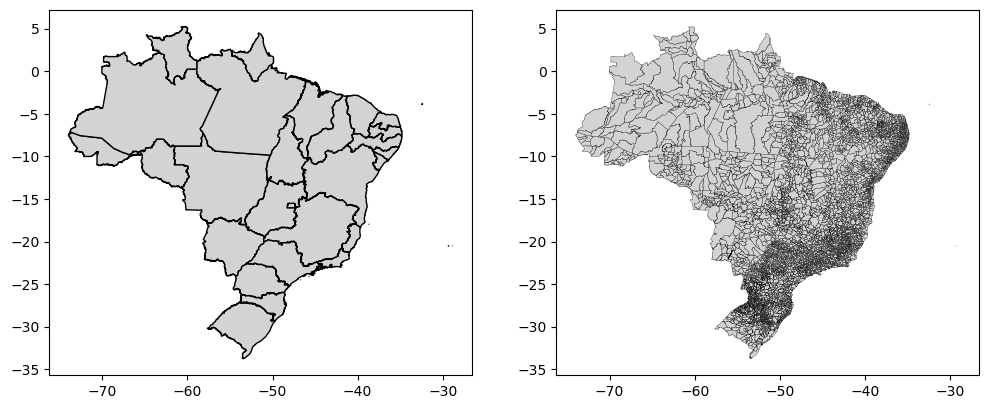

In [16]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(12,12))

brazil_states.plot(ax=ax1, facecolor='lightgrey', edgecolor='black')
brazil_municipalities.plot(ax=ax2, facecolor='lightgrey', edgecolor='black',linewidth=0.2)


Since we are using the crs 5641 for Brazil, the initial strategy could be to set the CRS with the right projection :

In [22]:
# brazil_states.to_crs(5641)

Python says _"Please set a crs on the object first"_. This would mean to know the actual projection, of the geometry:

In [19]:
brazil_states.geometry.head()

0    MULTIPOLYGON (((-68.87747 -11.01987, -68.88027...
1    POLYGON ((-35.46317 -8.82467, -35.46457 -8.828...
2    MULTIPOLYGON (((-50.46147 2.11133, -50.45627 2...
3    MULTIPOLYGON (((-58.49367 -0.84197, -58.48917 ...
4    MULTIPOLYGON (((-38.70687 -17.96447, -38.70867...
Name: geometry, dtype: geometry

From the plots above and the previous rows, we conclude the maps are unprojected map; then:

In [20]:
brazil_states.crs = "EPSG:4326"
brazil_municipalities.crs = "EPSG:4326"

Now, we can reproject:

In [21]:
brazil_states=brazil_states.to_crs(5641)
brazil_municipalities=brazil_municipalities.to_crs(5641)

### Exercise 2

<div class="alert-success">

1. Look for sub administrative divisions of your country
2. Check all the CRSs of those divisions
3. If you find one CRS is missing, fill the CRS with the right projection.
</div>

<a class="anchor" id="13"></a>

## Projecting Naive Points

You will get Lines and Polygons as maps for sure, but that may not be the case with points. These points came as a CSV file:

In [26]:
import pandas as pd 
infoairports=pd.read_csv(os.path.join("data","br-airports.csv"))

# see

infoairports

id        ident                 type  \
0     #meta +id  #meta +code  #loc +airport +type   
1          5910         SBGR        large_airport   
2          5906         SBGL        large_airport   
3          5974         SBSP       medium_airport   
4          5967         SBRJ       medium_airport   
...         ...          ...                  ...   
6667     345213         SD8M             heliport   
6668     309669         SSVR               closed   
6669     505308      BR-1760             heliport   
6670     341727      BR-1429             heliport   
6671     343017      BR-1493             heliport   

                                                   name latitude_deg  \
0                                   #loc +airport +name    #geo +lat   
1     Guarulhos - Governador André Franco Montoro In...   -23.431944   
2          Rio Galeão – Tom Jobim International Airport   -22.809999   
3                                     Congonhas Airport   -23.627657   
4                                 Santos Dumont Airport     -22.9105   
...                                                 ...          ...   
6667                       Fazenda Alegria - H Heliport    -4.334444   
6668                              Volta Redonda Airport     -22.4978   
6669                       Unimed Volta Redonda Helipad   -22.533988   
6670                              Santa Helena Heliport    -23.59851   
6671              Bandeiras Centro Empresarial Heliport   -23.536615   

     longitude_deg         elevation_ft                 continent  \
0        #geo +lon  #geo +elevation +ft  #region +continent +code   
1       -46.467778                 2461                        SA   
2       -43.250557                   28                        SA   
3       -46.654601                 2631                        SA   
4       -43.163101                   11                        SA   
...            ...                  ...                       ...   
6667    -45.359167                  135                        SA   
6668       -44.085                 1245                        SA   
6669    -44.076918                 1385                        SA   
6670    -47.441196                 2254                        SA   
6671    -47.449475                 1827                        SA   

        country_name           iso_country  ...              municipality  \
0     #country +name  #country +code +iso2  ...  #loc +municipality +name   
1             Brazil                    BR  ...                 São Paulo   
2             Brazil                    BR  ...            Rio De Janeiro   
3             Brazil                    BR  ...                 São Paulo   
4             Brazil                    BR  ...            Rio de Janeiro   
...              ...                   ...  ...                       ...   
6667          Brazil                    BR  ...           Vitorino Freire   
6668          Brazil                    BR  ...             Volta Redonda   
6669          Brazil                    BR  ...             Volta Redonda   
6670          Brazil                    BR  ...                Votorantim   
6671          Brazil                    BR  ...                Votorantim   

       scheduled_service                  gps_code                  iata_code  \
0     #status +scheduled  #loc +airport +code +gps  #loc +airport +code +iata   
1                      1                      SBGR                        GRU   
2                      1                      SBGL                        GIG   
3                      1                      SBSP                        CGH   
4                      1                      SBRJ                        SDU   
...                  ...                       ...                        ...   
6667                   0                      SD8M                        NaN   
6668                   0                       NaN                        NaN   
6669                   0    

This needs some cleaning, as the first row has column names, and some columns are not needed:

In [27]:
# bye first row 
infoairports.drop(index=0,inplace=True)
infoairports.reset_index(drop=True, inplace=True)

# keep the  columns needed
keep=['name','type','latitude_deg', 'longitude_deg','elevation_ft','region_name','municipality']
infoairports=infoairports.loc[:,keep]
infoairports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6671 entries, 0 to 6670
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           6671 non-null   object
 1   type           6671 non-null   object
 2   latitude_deg   6671 non-null   object
 3   longitude_deg  6671 non-null   object
 4   elevation_ft   6500 non-null   object
 5   region_name    6671 non-null   object
 6   municipality   6647 non-null   object
dtypes: object(7)
memory usage: 364.9+ KB


Some formatting is needed, because numeric data columns are not the right type:

In [28]:
numericCols=['latitude_deg', 'longitude_deg','elevation_ft']
infoairports[numericCols]=infoairports.loc[:,numericCols].apply(lambda x:pd.to_numeric(x))

# now 
infoairports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6671 entries, 0 to 6670
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6671 non-null   object 
 1   type           6671 non-null   object 
 2   latitude_deg   6671 non-null   float64
 3   longitude_deg  6671 non-null   float64
 4   elevation_ft   6500 non-null   float64
 5   region_name    6671 non-null   object 
 6   municipality   6647 non-null   object 
dtypes: float64(3), object(4)
memory usage: 364.9+ KB


<Axes: xlabel='longitude_deg', ylabel='latitude_deg'>

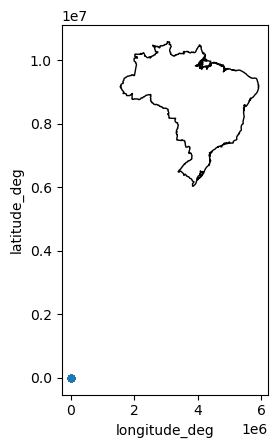

In [29]:
# let's plot

base = brazil.plot(color='white', edgecolor='black') #unprojected

infoairports.plot.scatter(x = 'longitude_deg', y = 'latitude_deg',ax=base)

We get it wrong because coordinates of both do not match. Let's try this:

1. Create a GeoDataFrame with the points, keeping them unprojected:

In [32]:
airports=gpd.GeoDataFrame(data=infoairports.copy(),
                 geometry=gpd.points_from_xy(infoairports.longitude_deg,
                                             infoairports.latitude_deg), 
                 crs=4326)# the coordinates were in degrees - unprojected

2. Reproject the GeoDataFrame:

In [33]:
airports=airports.to_crs(5641)

Does it look better?

<Axes: >

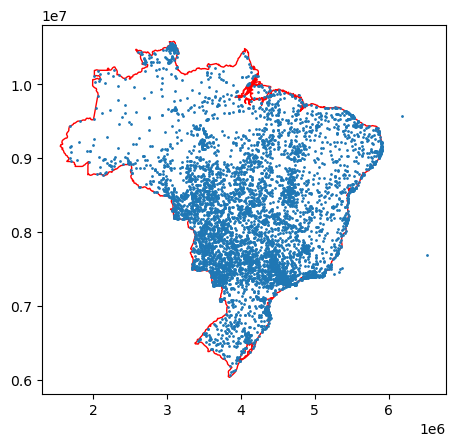

In [38]:
# let's plot

base = brazil.plot(color='white', edgecolor='red')
airports.plot(ax=base,markersize=1)

Now we have a spatial points:

In [40]:
#remember:
type(airports), type(infoairports)

(geopandas.geodataframe.GeoDataFrame, pandas.core.frame.DataFrame)

Remember you have type of airports:

In [41]:
airports['type'].value_counts() # this will not work: airports.type.value_counts()

type
small_airport     4587
heliport          1699
closed             251
medium_airport     124
large_airport        8
seaplane_base        2
Name: count, dtype: int64

We may use that in the future. For now, just give the **type** column a different name.

In [42]:
airports.rename(columns={'type':'kind'},inplace=True)

Let's play with this:

In [43]:
from folium import LayerControl


m = airports[airports.kind=='small_airport'].explore(color="red",name="small",show=False)
m = airports[airports.kind=='medium_airport'].explore(m=m, color="blue",name="medium",show=False)
m = airports[airports.kind=='large_airport'].explore(m=m, color="black",name="large",show=True)
m = airports[airports.kind=='seaplane_base'].explore(m=m, color="green",name="seaplane",show=False)
m = airports[airports.kind=='closed'].explore(m=m, color="white",name="closed",show=False)
m = airports[airports.kind=='heliport'].explore(m=m, color="orange",name="heliport",show=False)

LayerControl(collapsed=False).add_to(m) #optional

m


### Exercise 3 
<div class="alert-success">

1. Look for some points in a CSV file about your country.
    
2. Turn those points into a spatial object.
    
3. Save the layer.
    
</div>

<a class="anchor" id="2"></a>

## Dissolve and Union

Let me divide Brazil municipalities using the centroid of Brazil:

In [114]:
centroBrazil=brazil.centroid
centroBrazil

0    POINT (3884486.179 8756856.093)
dtype: geometry

Notice:

In [115]:
type(centroBrazil), type(centroBrazil.x)

(geopandas.geoseries.GeoSeries, pandas.core.series.Series)

The previous values are complex structures, not simple values. Then:

In [116]:
type(centroBrazil.x[0]),type(centroBrazil.y[0])

(numpy.float64, numpy.float64)

Let me now subset using  geopandas'  **cx**, which does subsetting **by location**:

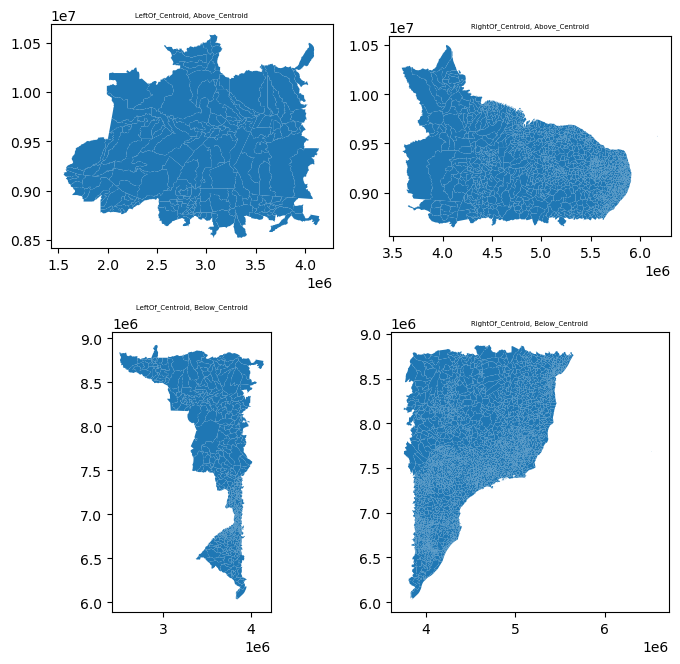

In [117]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharex=False, sharey=False,figsize=(8,8))

centroidX=centroBrazil.x[0]
centroidY=centroBrazil.y[0]

axs[0,0].set_title('LeftOf_Centroid, Above_Centroid',fontsize=5)
brazil_municipalities.cx[:centroidX,centroidY:].plot(ax=axs[0,0]) 

axs[0,1].set_title('RightOf_Centroid, Above_Centroid',fontsize=5)
brazil_municipalities.cx[centroidX:,centroidY:].plot(ax=axs[0,1]) 

axs[1,0].set_title('LeftOf_Centroid, Below_Centroid',fontsize=5)
brazil_municipalities.cx[:centroidX,:centroidY].plot(ax=axs[1,0]) 

axs[1,1].set_title('RightOf_Centroid, Below_Centroid',fontsize=5)
brazil_municipalities.cx[centroidX:,:centroidY].plot(ax=axs[1,1]) ;

You can create a polygon with one of these:

In [118]:
#instead of:
brazil_municipalities.cx[:centroidX,centroidY:]

ADM0_EN ADM0_PT ADM0_PCODE      ADM1_PT ADM1_PCODE  \
1     Brazil  Brasil         BR     Rondônia       BR11   
3     Brazil  Brasil         BR     Rondônia       BR11   
8     Brazil  Brasil         BR     Rondônia       BR11   
9     Brazil  Brasil         BR     Rondônia       BR11   
10    Brazil  Brasil         BR     Rondônia       BR11   
...      ...     ...        ...          ...        ...   
5305  Brazil  Brasil         BR  Mato Grosso       BR51   
5310  Brazil  Brasil         BR  Mato Grosso       BR51   
5313  Brazil  Brasil         BR  Mato Grosso       BR51   
5321  Brazil  Brasil         BR  Mato Grosso       BR51   
5324  Brazil  Brasil         BR  Mato Grosso       BR51   

                    ADM2_PT ADM2_PCODE  ET_ID  \
1                 Ariquemes  BR1100023      1   
3                    Cacoal  BR1100049      3   
8           Espigão D'Oeste  BR1100098      8   
9             Guajará-Mirim  BR1100106      9   
10                     Jaru  BR1100114     10   
...                     ...        ...    ...   
5305  São Félix do Araguaia  BR5107859   5305   
5310               Tabaporã  BR5107941   5310   
5313    Terra Nova do Norte  BR5108055   5313   
5321           Nova Guarita  BR5108808   5321   
5324       Nova Monte Verde  BR5108956   5324   

                                               geometry  
1     POLYGON ((2839173.154 8911097.984, 2838718.204...  
3     POLYGON ((2997393.730 8777661.276, 2997393.730...  
8     POLYGON ((3057637.194 8777929.305, 3056978.535...  
9     MULTIPOLYGON (((2708460.048 8727087.796, 27089...  
10    POLYGON ((2871236.909 8863979.571, 2871101.103...  
...                                                 ...  
5305  POLYGON ((3974265.397 8773180.057, 3974197.494...  
5310  POLYGON ((3505714.931 8812411.339, 3505972.962...  
5313  POLYGON ((3647944.371 8863821.903, 3657430.408...  
5321  POLYGON ((3638016.966 8872883.250, 3638098.449...  
5324  POLYGON ((3449722.190 8896410.060, 3449477.739...  

[191 rows x 9 columns]

Let's compare **dissolve** and **union** (_unary union_):

In [129]:
# dissolving
brazil_municipalities.cx[:centroidX,centroidY:].dissolve()

geometry ADM0_EN ADM0_PT  \
0  MULTIPOLYGON (((2121072.695 8774540.983, 21207...  Brazil  Brasil   

  ADM0_PCODE   ADM1_PT ADM1_PCODE    ADM2_PT ADM2_PCODE  ET_ID  
0         BR  Rondônia       BR11  Ariquemes  BR1100023      1

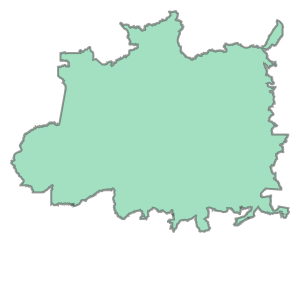

In [127]:
#uniting
brazil_municipalities.cx[:centroidX,centroidY:].unary_union

After uniting, you do not see the points. You need to convert the result into a geopandas geoseries:

In [128]:
gpd.GeoSeries(brazil_municipalities.cx[:centroidX,centroidY:].unary_union)

0    MULTIPOLYGON (((2121072.695 8774540.983, 21207...
dtype: geometry

They look the same, but _dissolve()_ can combine **by** groups:

<Axes: >

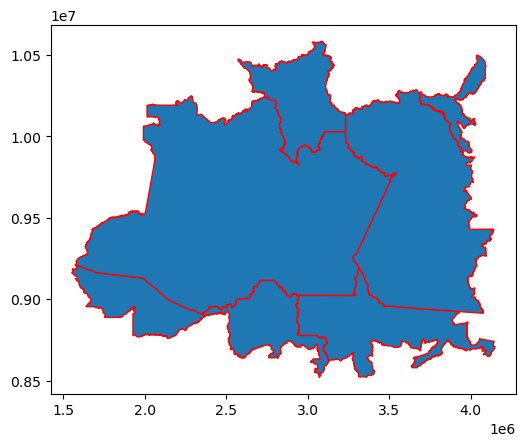

In [135]:
brazil_municipalities.cx[:centroidX,centroidY:].dissolve(by='ADM1_PT').plot(edgecolor='red')

Let's keep using use dissolve:

In [136]:
# you create
Brazil_topLeft=brazil_municipalities.cx[:centroidX,centroidY:].dissolve()
# you get
Brazil_topLeft

geometry ADM0_EN ADM0_PT  \
0  MULTIPOLYGON (((2121072.695 8774540.983, 21207...  Brazil  Brasil   

  ADM0_PCODE   ADM1_PT ADM1_PCODE    ADM2_PT ADM2_PCODE  ET_ID  
0         BR  Rondônia       BR11  Ariquemes  BR1100023      1

Aside from the geometry column, the rest in wrong, then:

In [137]:
Brazil_topLeft['zone']='NW'
Brazil_topLeft=Brazil_topLeft.loc[:,['ADM0_EN','zone','geometry']]   
Brazil_topLeft

ADM0_EN zone                                           geometry
0  Brazil   NW  MULTIPOLYGON (((2121072.695 8774540.983, 21207...

<Axes: >

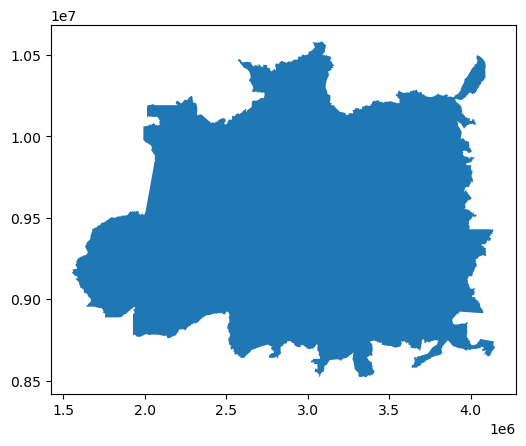

In [138]:
# this is the plot

Brazil_topLeft.plot()

We can do the same with the other parts:

In [139]:
Brazil_topRight=brazil_municipalities.cx[centroidX:,centroidY:].dissolve()
Brazil_bottomLeft=brazil_municipalities.cx[:centroidX,:centroidY].dissolve()
Brazil_bottomRight=brazil_municipalities.cx[centroidX:,:centroidY].dissolve()

Brazil_topRight['zone']='NE'
Brazil_topRight=Brazil_topRight.loc[:,['ADM0_EN','zone','geometry']] 

Brazil_bottomLeft['zone']='NE'
Brazil_bottomLeft=Brazil_bottomLeft.loc[:,['ADM0_EN','zone','geometry']] 

Brazil_bottomRight['zone']='NE'
Brazil_bottomRight=Brazil_bottomRight.loc[:,['ADM0_EN','zone','geometry']] 


Keep in mind that with **CX** you may not get a perfect partition:

In [140]:
rowsCX=(brazil_municipalities.cx[:centroBrazil.x[0],centroBrazil.y[0]:].shape[0],\
brazil_municipalities.cx[centroBrazil.x[0]:,centroBrazil.y[0]:].shape[0],\
brazil_municipalities.cx[:centroBrazil.x[0],:centroBrazil.y[0]].shape[0],\
brazil_municipalities.cx[centroBrazil.x[0]:,:centroBrazil.y[0]].shape[0])
sum(rowsCX)

5753

So, you have duplicated polygons across the zones:

In [141]:
sum(rowsCX)-brazil_municipalities.shape[0]

181

Take a look:

<Axes: >

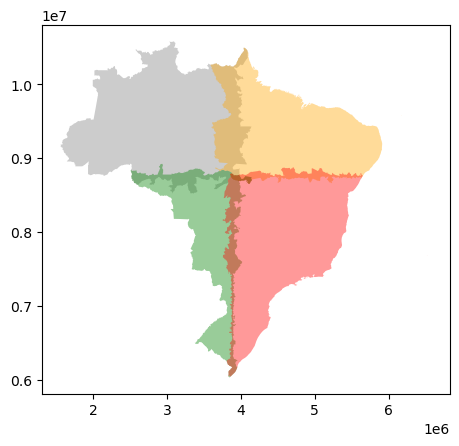

In [142]:
base=Brazil_topLeft.plot(facecolor='grey', alpha=0.4)
Brazil_topRight.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_bottomLeft.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_bottomRight.plot(ax=base,facecolor='red', alpha=0.4)


### Exercise 4


<div class="alert-success"> 

1. Compute the centroid of your country.

2. Dissolve all the polygons to the north, and also all the polygons to the south. Plot both results.

3. Detect the amount of duplicates after the dissolving process.

4. Plot both maps so that duplicates appear
    
</div>

<a class="anchor" id="31"></a>

## Creating the convex hull

Some time you may have the need to create a polygon that serves as an envelope to a set of points:

In [88]:
Brazil_AirTopLeft=airports[airports.kind=='medium_airport'].cx[:centroidX,centroidY:]
Brazil_AirTopRight=airports[airports.kind=='medium_airport'].cx[centroidX:,centroidY:]
Brazil_AirBottomLeft=airports[airports.kind=='medium_airport'].cx[:centroidX,:centroidY]
Brazil_AirBottomRight=airports[airports.kind=='medium_airport'].cx[centroidX:,:centroidY]

<Axes: >

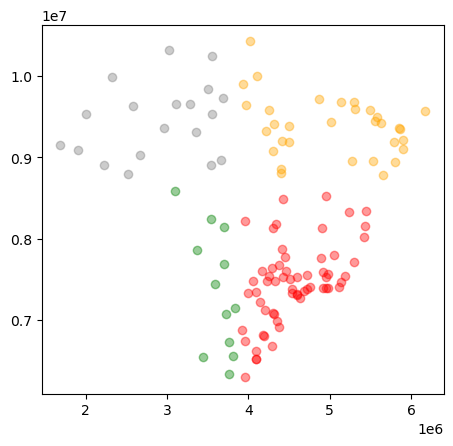

In [89]:
base=Brazil_AirTopLeft.plot(facecolor='grey', alpha=0.4)
Brazil_AirTopRight.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_AirBottomLeft.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_AirBottomRight.plot(ax=base,facecolor='red', alpha=0.4)

Notice we have simple points:

In [92]:
Brazil_AirBottomLeft

name            kind  latitude_deg  \
8              Cataratas International Airport  medium_airport    -25.594167   
15                        Campo Grande Airport  medium_airport    -20.469998   
20                     Marechal Rondon Airport  medium_airport    -15.652900   
50   Coronel Adalberto Mendes da Silva Airport  medium_airport    -25.000323   
75                          Ponta Porã Airport  medium_airport    -22.549601   
77                        Santo Ângelo Airport  medium_airport    -28.282503   
85              Maestro Marinho Franco Airport  medium_airport    -16.584292   
86                  Brigadeiro Camarão Airport  medium_airport    -12.694400   
105                        Santa Maria Airport  medium_airport    -29.711399   
141              Corumbá International Airport  medium_airport    -19.011930   
149                        Rubem Berta Airport  medium_airport    -29.782200   
237         Comandante Gustavo Kraemer Airport  medium_airport    -31.390499   

     longitude_deg  elevation_ft         region_name   municipality  \
8       -54.489444         786.0              Paraná  Foz do Iguaçu   
15      -54.673988        1833.0  Mato Grosso do Sul   Campo Grande   
20      -56.116699         617.0         Mato Grosso         Cuiabá   
50      -53.501208        2481.0              Paraná       Cascavel   
75      -55.702599        2156.0  Mato Grosso do Sul     Ponta Porã   
77      -54.169623        1056.0   Rio Grande do Sul   Santo Ângelo   
85      -54.724803        1467.0         Mato Grosso   Rondonópolis   
86      -60.098301        2018.0            Rondônia        Vilhena   
105     -53.688202         287.0   Rio Grande do Sul    Santa Maria   
141     -57.672772         463.0  Mato Grosso do Sul        Corumbá   
149     -57.038200         256.0   Rio Grande do Sul     Uruguaiana   
237     -54.112202         600.0   Rio Grande do Sul           Bagé   

                            geometry  
8    POINT (3721774.865 7071323.040)  
15   POINT (3701243.952 7687543.733)  
20   POINT (3540739.278 8248021.581)  
50   POINT (3831718.226 7143997.144)  
75   POINT (3586808.785 7440288.417)  
77   POINT (3757355.633 6737578.539)  
85   POINT (3695590.675 8140827.535)  
86   POINT (3097777.568 8585400.848)  
105  POINT (3810914.745 6556752.132)  
141  POINT (3367622.840 7858868.554)  
149  POINT (3438220.327 6547725.745)  
237  POINT (3763743.842 6340901.399)

In this situation, you can not make a _convex hull_:

<Axes: >

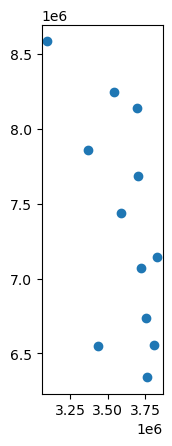

In [94]:
Brazil_AirBottomLeft.convex_hull.plot()

You first need to dissolve, and then you create a hull, an envelope of  convex angles:

<Axes: >

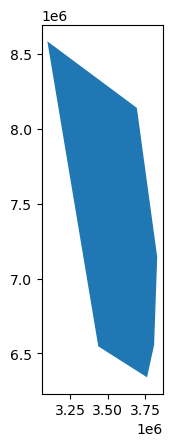

In [95]:
Brazil_AirBottomLeft.dissolve().convex_hull.plot()

As we saw, the convex hull is a polygon: 

In [97]:
Brazil_AirBottomLeft.dissolve().convex_hull

0    POLYGON ((3763743.842 6340901.399, 3438220.327...
dtype: geometry

We can make hulls from any spatial object:

<Axes: >

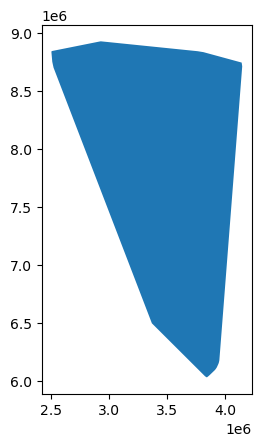

In [100]:
# SW of Brazil as convex hull
Brazil_bottomLeft.convex_hull.plot()

In this last case, what if we the polygons had not been dissolved?

<Axes: >

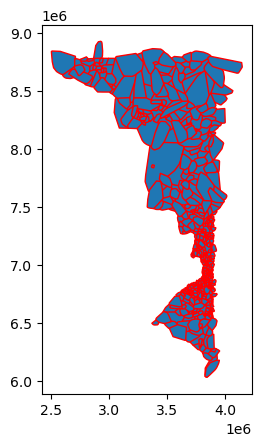

In [103]:
brazil_municipalities.cx[:centroidX,:centroidY].convex_hull.plot(edgecolor='red')

That is, you get a convex hull for each row of the geometry. 

We can also use _union_ before creating a convex hull:

In [149]:
# just the union
large_airport=airports[airports.kind=='large_airport']
gpd.GeoSeries(large_airport.unary_union)

0    MULTIPOINT (3103184.311 9664051.584, 4382272.3...
dtype: geometry

In [150]:
# hull of the union
gpd.GeoSeries(large_airport.unary_union.convex_hull)

0    POLYGON ((4382272.317 6814299.684, 3103184.311...
dtype: geometry

Let's turn the GS into a GDF:

In [145]:
# as gdf
LargeAirport_hull=gpd.GeoSeries(large_airport.unary_union.convex_hull).to_frame()
LargeAirport_hull

0
0  POLYGON ((4382272.317 6814299.684, 3103184.311...

In [151]:
#next steps
LargeAirport_hull.rename(columns={0:'geometry'},inplace=True)
LargeAirport_hull['name']='large airports hull' # optional
LargeAirport_hull=LargeAirport_hull.set_geometry('geometry')
LargeAirport_hull.crs="EPSG:5641"
# verifying:
LargeAirport_hull.crs

<Projected CRS: EPSG:5641>
Name: SIRGAS 2000 / Brazil Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Brazil - offshore - equatorial margin.
- bounds: (-51.64, -5.74, -32.43, 7.04)
Coordinate Operation:
- name: Petrobras Mercator
- method: Mercator (variant B)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Let's use the GDF in plotting:

<Axes: >

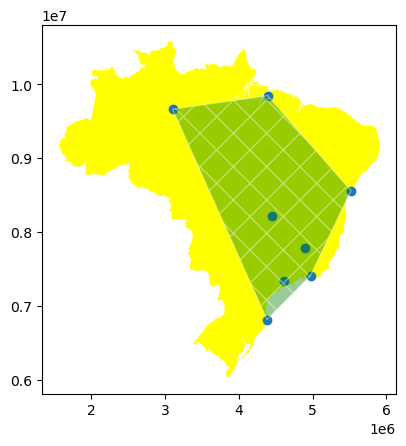

In [152]:
base=brazil.plot(facecolor='yellow')
large_airport.plot(ax=base)
LargeAirport_hull.plot(ax=base,facecolor='green',
                       edgecolor='white',alpha=0.4,
                       hatch='X')

### Exercise 5 

<div class="alert-success">

1. Select some points from your maps.
    
2. Create the convex hull for those points.
    
3. Turn the hull into a GDF.
    
4. Plot the hull on top of the country.
    
</div>

## Spatial Overlay

We might need to create or find some geometries from the geometries we already have. Using a set theory approach, we will se the use of _intersection_, _union_, _difference_, and _symmetric difference_.

Let me create this GeoDFs:

In [166]:
# the north
MunisN_brazil=brazil_municipalities.cx[:,centroidY:]
# the south
MunisS_brazil=brazil_municipalities.cx[:,:centroidY]
# the west
MunisW_brazil=brazil_municipalities.cx[:centroidX,:]
# the east
MunisE_brazil=brazil_municipalities.cx[centroidX:,:]

### Intersection

We keep what id common in both GeoDFs:

<Axes: >

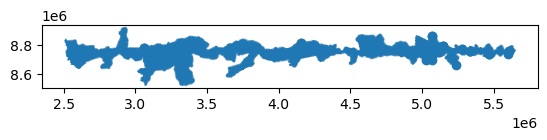

In [170]:
munisMidNS_brazil=MunisN_brazil.overlay(MunisS_brazil, how="intersection",keep_geom_type=False)
munisMidNS_brazil.plot()

<Axes: >

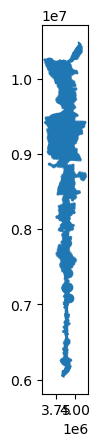

In [171]:
munisMidWE_brazil=MunisW_brazil.overlay(MunisE_brazil, how="intersection",keep_geom_type=False)
munisMidWE_brazil.plot()

### Union

We combine all the geometries in two GeoDFs. Let me try to combine the previous results:

In [183]:
munisMidNS_brazil.overlay(munisMidWE_brazil, how="union",keep_geom_type=False)

NotImplementedError: df1 contains mixed geometry types.

In [ ]:
The erros appears because of the mixed geometries:

In [201]:
munisMidNS_brazil.geometry

0      POLYGON ((2997393.730 8770664.256, 2997393.730...
1      MULTILINESTRING ((2973885.741 8717181.041, 297...
2      MULTILINESTRING ((2914898.482 8739124.549, 291...
3      MULTILINESTRING ((2949854.901 8778190.460, 294...
4      MULTILINESTRING ((2997393.730 8777661.276, 295...
                             ...                        
508    MULTILINESTRING ((3557681.030 8707402.015, 355...
509    MULTILINESTRING ((4072704.249 8681265.827, 407...
510    MULTILINESTRING ((4141225.078 8694636.438, 414...
511    MULTILINESTRING ((4100035.171 8655058.897, 409...
512    MULTILINESTRING ((3577583.374 8728491.975, 357...
Name: geometry, Length: 513, dtype: geometry

In [202]:
munisMidWE_brazil.geometry

0      MULTILINESTRING ((3658075.486 10100138.042, 36...
1      POLYGON ((3678745.132 10268249.158, 3678914.89...
2      MULTILINESTRING ((3680313.690 10041164.018, 36...
3      MULTILINESTRING ((3586240.995 10265663.559, 35...
4      MULTILINESTRING ((3887512.636 9807323.910, 388...
                             ...                        
849    MULTILINESTRING ((3953296.978 8062314.412, 395...
850    MULTILINESTRING ((3964643.554 8024973.458, 396...
851    MULTILINESTRING ((3987526.836 8045183.626, 398...
852    MULTILINESTRING ((3920574.564 8067720.124, 392...
853    MULTILINESTRING ((3973722.174 7998612.573, 397...
Name: geometry, Length: 854, dtype: geometry

The strategy should be to dissolve both before the union:

In [204]:
munisMidNS_brazil.dissolve().overlay(munisMidWE_brazil.dissolve(), how="union",keep_geom_type=False).geometry

0    GEOMETRYCOLLECTION (POLYGON ((3874271.568 8795...
1    MULTIPOLYGON (((3974666.024 8772884.495, 39748...
2    MULTIPOLYGON (((3657430.408 10100536.038, 3655...
Name: geometry, dtype: geometry

Or to apply *unary_union*:

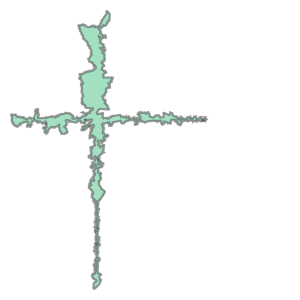

In [185]:
munisMidNS_brazil.dissolve().overlay(munisMidWE_brazil.dissolve(), how="union",keep_geom_type=False).unary_union

Let me use dissolve, and dissolve the result:

In [205]:
munisMidNS_brazil.dissolve().overlay(munisMidWE_brazil.dissolve(), how="union",keep_geom_type=False).dissolve()

geometry ADM0_EN_1_1 ADM0_PT_1_1  \
0  MULTIPOLYGON (((3873986.376 6739975.639, 38736...      Brazil      Brasil   

  ADM0_PCODE_1_1 ADM1_PT_1_1 ADM1_PCODE_1_1 ADM2_PT_1_1 ADM2_PCODE_1_1  \
0             BR    Rondônia           BR11      Cacoal      BR1100049   

   ET_ID_1_1 ADM0_EN_2_1  ... ADM2_PCODE_1_2 ET_ID_1_2 ADM0_EN_2_2  \
0        3.0      Brazil  ...      BR1500404     156.0      Brazil   

  ADM0_PT_2_2 ADM0_PCODE_2_2 ADM1_PT_2_2  ADM1_PCODE_2_2 ADM2_PT_2_2  \
0      Brasil             BR        Pará            BR15    Almeirim   

  ADM2_PCODE_2_2 ET_ID_2_2  
0      BR1500503     157.0  

[1 rows x 33 columns]

<Axes: >

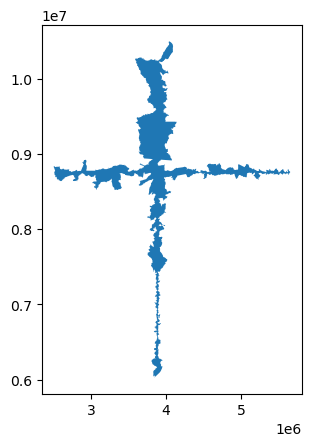

In [206]:
munisMidNS_brazil.dissolve().overlay(munisMidWE_brazil.dissolve(), how="union",keep_geom_type=False).dissolve().plot()

Let me create an object to save the previous result:

In [211]:
muniMidBrazil=munisMidNS_brazil.dissolve().overlay(munisMidWE_brazil.dissolve(), how="union",keep_geom_type=False).dissolve()
muniMidBrazil

geometry ADM0_EN_1_1 ADM0_PT_1_1  \
0  MULTIPOLYGON (((3873986.376 6739975.639, 38736...      Brazil      Brasil   

  ADM0_PCODE_1_1 ADM1_PT_1_1 ADM1_PCODE_1_1 ADM2_PT_1_1 ADM2_PCODE_1_1  \
0             BR    Rondônia           BR11      Cacoal      BR1100049   

   ET_ID_1_1 ADM0_EN_2_1  ... ADM2_PCODE_1_2 ET_ID_1_2 ADM0_EN_2_2  \
0        3.0      Brazil  ...      BR1500404     156.0      Brazil   

  ADM0_PT_2_2 ADM0_PCODE_2_2 ADM1_PT_2_2  ADM1_PCODE_2_2 ADM2_PT_2_2  \
0      Brasil             BR        Pará            BR15    Almeirim   

  ADM2_PCODE_2_2 ET_ID_2_2  
0      BR1500503     157.0  

[1 rows x 33 columns]

In [212]:
# some cleaning

muniMidBrazil['zone']='middles'
muniMidBrazil=muniMidBrazil.loc[:,['ADM0_EN_1_1','zone','geometry']]   
muniMidBrazil

ADM0_EN_1_1     zone                                           geometry
0      Brazil  middles  MULTIPOLYGON (((3873986.376 6739975.639, 38736...

### Difference

Here, you keep what belongs to the GeoDF to left that is not in the GeoDF to the right:

<Axes: >

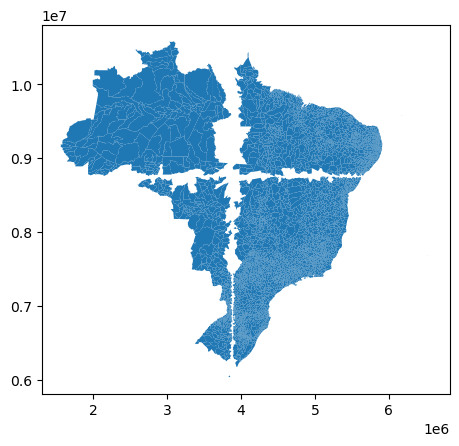

In [213]:
# with the municipalities
brazil_municipalities.overlay(muniMidBrazil, how='difference').plot()

<Axes: >

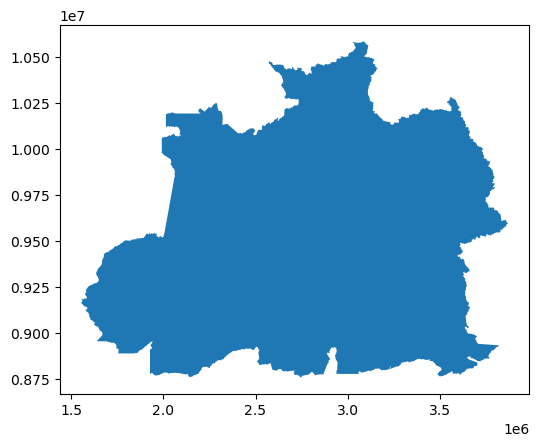

In [191]:
# with the zones
Brazil_topLeft.overlay(muniMidBrazil, how='difference').plot()

### Symmetric Difference

This is the opposite to *intersection*, you keep what is not in the intersection:

<Axes: >

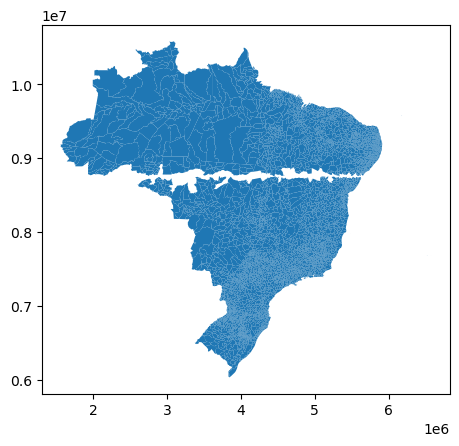

In [214]:
MunisN_brazil.overlay(MunisS_brazil, how="symmetric_difference",keep_geom_type=False).plot()

<Axes: >

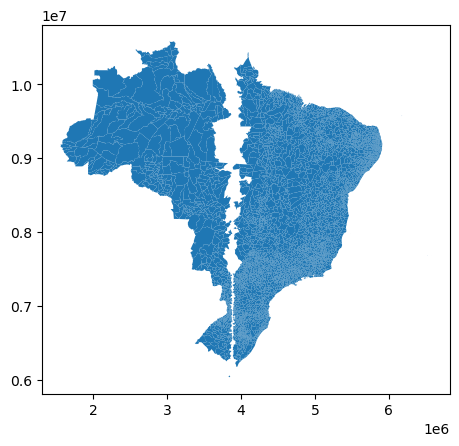

In [198]:
MunisW_brazil.overlay(MunisE_brazil, how="symmetric_difference",keep_geom_type=False).plot()

### Exercise 6 

<div class="alert-success">

1. Apply two of these operations to your maps.
2. Apply two of these operations to these  maps.
        
</div>

In [229]:
# hulls for the mid size airports:
Brazil_AirTopLeft_hull=Brazil_AirTopLeft.dissolve().convex_hull
Brazil_AirTopRight_hull=Brazil_AirTopRight.dissolve().convex_hull
Brazil_AirBottomLeft_hull=Brazil_AirBottomLeft.dissolve().convex_hull
Brazil_AirBottomRight_hull=Brazil_AirBottomRight.dissolve().convex_hull

<Axes: >

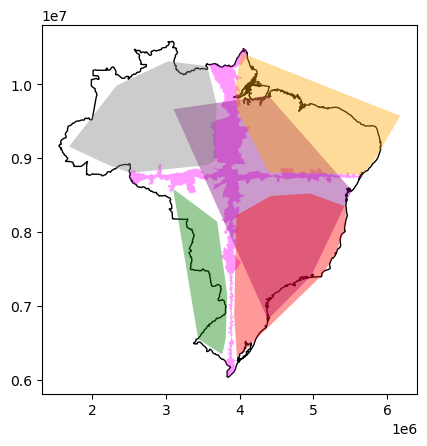

In [227]:
base = brazil.plot(color='white', edgecolor='black') #unprojected
muniMidBrazil.plot(ax=base,facecolor='magenta',alpha=0.4) #unprojected
LargeAirport_hull.plot(ax=base,facecolor='purple',alpha=0.4)
Brazil_AirTopLeft_hull.plot(ax=base,facecolor='grey', alpha=0.4)
Brazil_AirTopRight_hull.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_AirBottomLeft_hull.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_AirBottomRight_hull.plot(ax=base,facecolor='red', alpha=0.4)

<a class="anchor" id="4"></a>

## Validity of Geometry

Geometries are created in a way that some issues may appear, especially in (multi) polygons.
Let's check if our recent maps on states and municipalities are valid:

In [230]:
# non valid
brazil_municipalities[~brazil_municipalities.is_valid]

ADM0_EN ADM0_PT ADM0_PCODE   ADM1_PT ADM1_PCODE                 ADM2_PT  \
5     Brazil  Brasil         BR  Rondônia       BR11       Colorado do Oeste   
15    Brazil  Brasil         BR  Rondônia       BR11           Pimenta Bueno   
16    Brazil  Brasil         BR  Rondônia       BR11             Porto Velho   
22    Brazil  Brasil         BR  Rondônia       BR11   São Miguel do Guaporé   
36    Brazil  Brasil         BR  Rondônia       BR11         Itapuã do Oeste   
...      ...     ...        ...       ...        ...                     ...   
5464  Brazil  Brasil         BR     Goiás       BR52               Matrinchã   
5470  Brazil  Brasil         BR     Goiás       BR52   Monte Alegre de Goiás   
5471  Brazil  Brasil         BR     Goiás       BR52  Montes Claros de Goiás   
5496  Brazil  Brasil         BR     Goiás       BR52          Padre Bernardo   
5512  Brazil  Brasil         BR     Goiás       BR52               Pontalina   

     ADM2_PCODE  ET_ID                                           geometry  
5     BR1100064      5  POLYGON ((3071557.291 8521541.630, 3071367.162...  
15    BR1100189     15  POLYGON ((3057168.663 8724320.552, 3056869.891...  
16    BR1100205     16  POLYGON ((2856305.059 9048717.998, 2857038.410...  
22    BR1100320     22  POLYGON ((2753262.389 8765192.063, 2753595.113...  
36    BR1101104     36  POLYGON ((2801256.168 9023884.917, 2801099.991...  
...         ...    ...                                                ...  
5464  BR5212956   5464  POLYGON ((4141197.917 8313421.144, 4140885.563...  
5470  BR5213509   5470  POLYGON ((4616158.417 8544511.406, 4616233.111...  
5471  BR5213707   5471  MULTIPOLYGON (((4066884.969 8218654.089, 40667...  
5496  BR5215603   5496  POLYGON ((4404321.702 8311359.407, 4404056.880...  
5512  BR5217708   5512  POLYGON ((4263830.576 8058646.220, 4264122.559...  

[256 rows x 9 columns]

<Axes: >

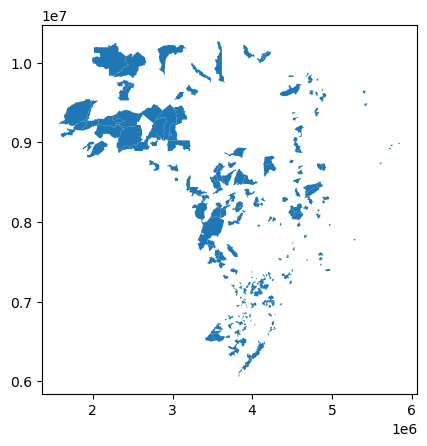

In [231]:
# see the invalid:
brazil_municipalities[~brazil_municipalities.is_valid].plot()

It is difficult to see what is wrong. Let's get some information:

In [232]:
# what is wrong?

from shapely.validation import explain_validity, make_valid

explain_validity(brazil_municipalities[~brazil_municipalities.is_valid].geometry)

5       Ring Self-intersection[3068508.44978257 851673...
15      Ring Self-intersection[3065079.35271118 868017...
16      Ring Self-intersection[2697459.77578448 903418...
22      Ring Self-intersection[2708460.04757785 872708...
36      Ring Self-intersection[2793277.57533772 901160...
                              ...                        
5464    Ring Self-intersection[4134149.59432842 826732...
5470    Ring Self-intersection[4579443.31264052 849053...
5471    Ring Self-intersection[4016405.94439198 821413...
5496    Ring Self-intersection[4404321.70180657 831135...
5512    Ring Self-intersection[4261277.42674537 804649...
Name: geometry, Length: 256, dtype: object

In [233]:
# varieties?
brazil_municipalities['validity']=[x.split('[')[0] for x in brazil_municipalities.geometry.apply(lambda x: explain_validity(x))]
brazil_municipalities['validity'].value_counts()

validity
Valid Geometry            5316
Ring Self-intersection     256
Name: count, dtype: int64

In [234]:
# solving the issue:
brazil_municipalities.drop(columns=['validity'],inplace=True)

brazil_municipalities_valid=brazil_municipalities.copy()

brazil_municipalities_valid['geometry'] = [make_valid(row)  if not row.is_valid else row for row in brazil_municipalities_valid['geometry'] ]
#any invalid?
brazil_municipalities_valid[~brazil_municipalities_valid.is_valid]

Empty GeoDataFrame
Columns: [ADM0_EN, ADM0_PT, ADM0_PCODE, ADM1_PT, ADM1_PCODE, ADM2_PT, ADM2_PCODE, ET_ID, geometry]
Index: []

The _solution_ we got may help for some advanced techniques, but may also give us some extra trouble. Notice that once geopandas solved the problem, you  have created **collections**:

In [235]:
[x for x in brazil_municipalities_valid["geometry"]]

[<POLYGON ((2880702.575 8678970.18, 2881137.154 8678859.874, 2881660.006 8679...>,
 <POLYGON ((2839173.154 8911097.984, 2838718.204 8910885.753, 2838439.802 891...>,
 <POLYGON ((3067184.343 8504324.153, 3067191.133 8503935.715, 3066838.038 850...>,
 <POLYGON ((2997393.73 8777661.276, 2997393.73 8770664.256, 2997393.73 874828...>,
 <POLYGON ((2974496.868 8540812.592, 2974897.495 8540570.143, 2975467.879 854...>,
 <POLYGON ((3071367.162 8521146.506, 3071421.485 8520522.615, 3071278.889 852...>,
 <POLYGON ((3036268.147 8552904.635, 3035500.844 8552565.354, 3034896.508 855...>,
 <POLYGON ((2699327.106 8704013.071, 2699571.556 8703689.311, 2699659.83 8703...>,
 <POLYGON ((3057637.194 8777929.305, 3056978.535 8777571.933, 3056645.811 877...>,
 <MULTIPOLYGON (((2708460.048 8727087.796, 2708928.578 8727005.195, 2709071.1...>,
 <POLYGON ((2871236.909 8863979.571, 2871101.103 8863431.157, 2870931.346 886...>,
 <POLYGON ((2933666.847 8920914.042, 2933571.782 8920496.537, 2933789.072 892...>,
 <PO

In [244]:
pd.Series([type(x) for x in brazil_municipalities_valid.geometry]).value_counts()

<class 'shapely.geometry.polygon.Polygon'>                  5104
<class 'shapely.geometry.multipolygon.MultiPolygon'>         456
<class 'shapely.geometry.collection.GeometryCollection'>      12
Name: count, dtype: int64

In [245]:
brazil.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='country', driver="GPKG")
brazil_cities.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='cities', driver="GPKG")
brazil_rivers.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='rivers', driver="GPKG")
airports.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='airports', driver="GPKG")
brazil_border.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='border', driver="GPKG")
brazil_states.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='states', driver="GPKG")
brazil_municipalities.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='municipalities', driver="GPKG")